# Import

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

import copy
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV

In [2]:
data_dir = "structured"
csv_file = os.path.join(os.getcwd(),"..","data", data_dir, "075m_all_concat.csv")
df = pd.read_csv(csv_file)
print('Total:',len(df))
df.head()

Total: 74250


,x_c_l,y_c_l,z_c_l,x_c_r,y_c_r,z_c_r,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye_pan,...,l_rvec_2,l_tvec_0,l_tvec_1,l_tvec_2,r_rvec_0,r_rvec_1,r_rvec_2,r_tvec_0,r_tvec_1,r_tvec_2
0,-0.873669,-0.334702,0.738088,-1.166921,-0.352033,0.738508,-35,-10,-10,-14,...,0.040561,-0.058313,-0.220058,-0.025247,0.156209,-0.749052,0.049460,-0.006449,-0.216973,0.003556
1,-0.821681,-0.331576,0.738000,-0.997318,-0.340332,0.738221,-35,-10,-10,-12,...,0.040659,-0.056857,-0.221480,-0.025029,0.153847,-0.675968,0.049134,-0.006025,-0.218582,0.003275
2,-0.731501,-0.324165,0.738176,-0.868484,-0.332085,0.738360,-35,-10,-10,-10,...,0.044023,-0.057698,-0.221366,-0.024965,0.151740,-0.609258,0.051079,-0.005431,-0.218897,0.004023
3,-0.672994,-0.320809,0.737795,-0.776648,-0.327031,0.737932,-35,-10,-10,-8,...,0.046952,-0.056153,-0.220476,-0.023398,0.152025,-0.553739,0.053352,-0.005492,-0.217724,0.003949
4,-0.613507,-0.317492,0.737656,-0.690487,-0.321762,0.737752,-35,-10,-10,-6,...,0.050062,-0.054760,-0.220760,-0.024545,0.150643,-0.494342,0.055436,-0.005764,-0.217606,0.003346


In [3]:
# Filtered df
temp_df = df[~df.isin([-100.0]).any(axis=1)]
valid_df = temp_df[~temp_df.isin([-180.17578125]).any(axis=1)]
valid_df = valid_df.reset_index(drop=True)
print('Valid:',len(valid_df))
print('Removed:', len(df)-len(valid_df))
valid_df.head()

Valid: 72627
Removed: 1623


,x_c_l,y_c_l,z_c_l,x_c_r,y_c_r,z_c_r,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye_pan,...,l_rvec_2,l_tvec_0,l_tvec_1,l_tvec_2,r_rvec_0,r_rvec_1,r_rvec_2,r_tvec_0,r_tvec_1,r_tvec_2
0,-0.873669,-0.334702,0.738088,-1.166921,-0.352033,0.738508,-35,-10,-10,-14,...,0.040561,-0.058313,-0.220058,-0.025247,0.156209,-0.749052,0.049460,-0.006449,-0.216973,0.003556
1,-0.821681,-0.331576,0.738000,-0.997318,-0.340332,0.738221,-35,-10,-10,-12,...,0.040659,-0.056857,-0.221480,-0.025029,0.153847,-0.675968,0.049134,-0.006025,-0.218582,0.003275
2,-0.731501,-0.324165,0.738176,-0.868484,-0.332085,0.738360,-35,-10,-10,-10,...,0.044023,-0.057698,-0.221366,-0.024965,0.151740,-0.609258,0.051079,-0.005431,-0.218897,0.004023
3,-0.672994,-0.320809,0.737795,-0.776648,-0.327031,0.737932,-35,-10,-10,-8,...,0.046952,-0.056153,-0.220476,-0.023398,0.152025,-0.553739,0.053352,-0.005492,-0.217724,0.003949
4,-0.613507,-0.317492,0.737656,-0.690487,-0.321762,0.737752,-35,-10,-10,-6,...,0.050062,-0.054760,-0.220760,-0.024545,0.150643,-0.494342,0.055436,-0.005764,-0.217606,0.003346


In [4]:
# IQP Outlier Removal

cols = ['x_c_l', 'y_c_l', 'z_c_l', 'x_c_r', 'y_c_r', 'z_c_r', 
        'l_rvec_0','l_rvec_1','l_rvec_2','l_tvec_0','l_tvec_1','l_tvec_2',
        'r_rvec_0','r_rvec_1','r_rvec_2','r_tvec_0','r_tvec_1','r_tvec_2']

for col in cols:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = valid_df[col].quantile(0.25)
    Q3 = valid_df[col].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to remove outliers
    valid_df = valid_df[(valid_df[col] >= lower_bound) & (valid_df[col] <= upper_bound)]

print(valid_df.shape)
valid_df.head()

(47719, 32)


,x_c_l,y_c_l,z_c_l,x_c_r,y_c_r,z_c_r,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye_pan,...,l_rvec_2,l_tvec_0,l_tvec_1,l_tvec_2,r_rvec_0,r_rvec_1,r_rvec_2,r_tvec_0,r_tvec_1,r_tvec_2
4,-0.613507,-0.317492,0.737656,-0.690487,-0.321762,0.737752,-35,-10,-10,-6,...,0.050062,-0.054760,-0.220760,-0.024545,0.150643,-0.494342,0.055436,-0.005764,-0.217606,0.003346
5,-0.551371,-0.313438,0.737570,-0.614298,-0.317635,0.737655,-35,-10,-10,-4,...,0.053653,-0.053737,-0.220335,-0.022744,0.150443,-0.437359,0.058225,-0.004930,-0.216733,0.004052
6,-0.488732,-0.307404,0.737476,-0.554609,-0.313155,0.737581,-35,-10,-10,-2,...,0.055293,-0.052636,-0.219974,-0.021508,0.149372,-0.387982,0.058767,-0.004440,-0.216226,0.004077
7,-0.438227,-0.303246,0.737435,-0.493794,-0.308266,0.737530,-35,-10,-10,0,...,0.056096,-0.052337,-0.220840,-0.022441,0.147074,-0.335100,0.058641,-0.002797,-0.216476,0.004828
8,-0.381455,-0.297903,0.737400,-0.425342,-0.303679,0.737497,-35,-10,-10,2,...,0.057679,-0.051884,-0.219850,-0.021891,0.145017,-0.268584,0.060020,-0.002541,-0.216501,0.005089


In [5]:
# Filtered df
filtered_df = valid_df.reset_index(drop=True)
print("Final:",len(filtered_df))
print("Removed:",len(df)-len(filtered_df))
filtered_df.head()

Final: 47719
Removed: 26531


,x_c_l,y_c_l,z_c_l,x_c_r,y_c_r,z_c_r,cmd_theta_lower_neck_pan,cmd_theta_lower_neck_tilt,cmd_theta_upper_neck_tilt,cmd_theta_left_eye_pan,...,l_rvec_2,l_tvec_0,l_tvec_1,l_tvec_2,r_rvec_0,r_rvec_1,r_rvec_2,r_tvec_0,r_tvec_1,r_tvec_2
0,-0.613507,-0.317492,0.737656,-0.690487,-0.321762,0.737752,-35,-10,-10,-6,...,0.050062,-0.054760,-0.220760,-0.024545,0.150643,-0.494342,0.055436,-0.005764,-0.217606,0.003346
1,-0.551371,-0.313438,0.737570,-0.614298,-0.317635,0.737655,-35,-10,-10,-4,...,0.053653,-0.053737,-0.220335,-0.022744,0.150443,-0.437359,0.058225,-0.004930,-0.216733,0.004052
2,-0.488732,-0.307404,0.737476,-0.554609,-0.313155,0.737581,-35,-10,-10,-2,...,0.055293,-0.052636,-0.219974,-0.021508,0.149372,-0.387982,0.058767,-0.004440,-0.216226,0.004077
3,-0.438227,-0.303246,0.737435,-0.493794,-0.308266,0.737530,-35,-10,-10,0,...,0.056096,-0.052337,-0.220840,-0.022441,0.147074,-0.335100,0.058641,-0.002797,-0.216476,0.004828
4,-0.381455,-0.297903,0.737400,-0.425342,-0.303679,0.737497,-35,-10,-10,2,...,0.057679,-0.051884,-0.219850,-0.021891,0.145017,-0.268584,0.060020,-0.002541,-0.216501,0.005089


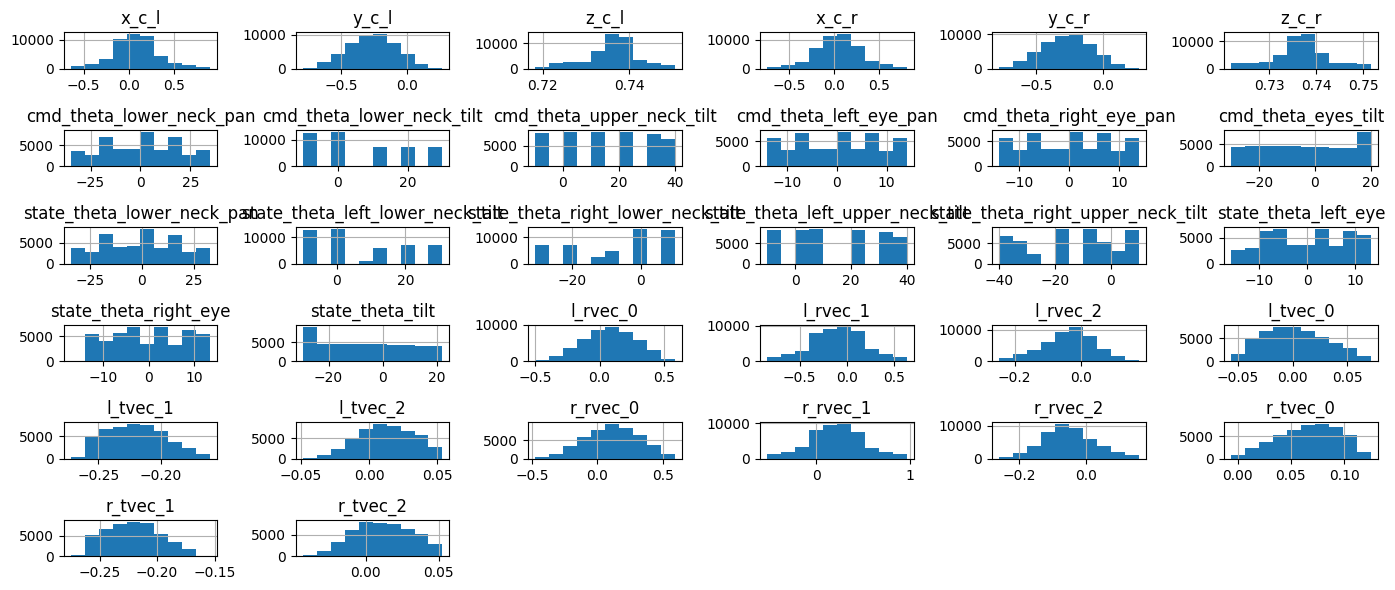

In [6]:
filtered_df.hist(figsize=(14,6))
plt.tight_layout()
plt.show()

# Inverse the Pose

## Left Eye Camera

In [7]:
# Getting the Data
left_data_arr = filtered_df[['l_rvec_0','l_rvec_1','l_rvec_2',
                                 'l_tvec_0','l_tvec_1','l_tvec_2']].to_numpy()
print(left_data_arr.shape)

(47719, 6)


In [8]:
# Computation
left_rvec_tvec_list = []
for i in range(left_data_arr.shape[0]):
    temp_arr = np.eye(4)
    rot_mat, _ = cv2.Rodrigues(left_data_arr[i,:3])
    temp_arr[:3,:3] = rot_mat
    temp_arr[:3,3] = left_data_arr[i,3:]
    inv_arr = np.linalg.inv(temp_arr)
    l_rvec,_ = cv2.Rodrigues(inv_arr[:3,:3])
    l_rvec_tvec = np.concatenate([l_rvec.flatten(), inv_arr[:3,3].flatten()])
    left_rvec_tvec_list.append(l_rvec_tvec)
left_rvec_tvec_arr = np.array(left_rvec_tvec_list)
print(left_rvec_tvec_arr.shape)

(47719, 6)


## Right Eye Camera

In [9]:
# Getting the Data
right_data_arr = filtered_df[['r_rvec_0','r_rvec_1','r_rvec_2',
                                   'r_tvec_0','r_tvec_1','r_tvec_2']].to_numpy()
print(right_data_arr.shape)

(47719, 6)


In [10]:
# Computation
right_rvec_tvec_list = []
for i in range(right_data_arr.shape[0]):
    temp_arr = np.eye(4)
    rot_mat, _ = cv2.Rodrigues(right_data_arr[i,:3])
    temp_arr[:3,:3] = rot_mat
    temp_arr[:3,3] = right_data_arr[i,3:]
    inv_arr = np.linalg.inv(temp_arr)
    r_rvec,_ = cv2.Rodrigues(inv_arr[:3,:3])
    r_rvec_tvec = np.concatenate([r_rvec.flatten(), inv_arr[:3,3].flatten()])
    right_rvec_tvec_list.append(r_rvec_tvec)
right_rvec_tvec_arr = np.array(right_rvec_tvec_list)
print(right_rvec_tvec_arr.shape)

(47719, 6)


## Changing the Values in the DataFrame

In [11]:
saved_df = filtered_df.copy()

saved_df['l_rvec_0'] = left_rvec_tvec_arr[:,0]
saved_df['l_rvec_1'] = left_rvec_tvec_arr[:,1]
saved_df['l_rvec_2'] = left_rvec_tvec_arr[:,2]
saved_df['l_tvec_0'] = left_rvec_tvec_arr[:,3]
saved_df['l_tvec_1'] = left_rvec_tvec_arr[:,4]
saved_df['l_tvec_2'] = left_rvec_tvec_arr[:,5]

saved_df['r_rvec_0'] = right_rvec_tvec_arr[:,0]
saved_df['r_rvec_1'] = right_rvec_tvec_arr[:,1]
saved_df['r_rvec_2'] = right_rvec_tvec_arr[:,2]
saved_df['r_tvec_0'] = right_rvec_tvec_arr[:,3]
saved_df['r_tvec_1'] = right_rvec_tvec_arr[:,4]
saved_df['r_tvec_2'] = right_rvec_tvec_arr[:,5]

# Saving the Final CSV

In [12]:
data_dir = 'final'
filepath = os.path.join(os.getcwd(),"..","data", data_dir, "241001_075m_grace_dataset.csv")
saved_df.to_csv(filepath, index=False)
print('Saved to:', filepath)

Saved to: /home/jaynieles/dev/grace_dl/notebooks/../data/final/241001_075m_grace_dataset.csv
